In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from collections import Counter
import matplotlib as mpl



In [2]:
# import species and parks data
species = pd.read_csv('species.csv')
del species['Unnamed: 13'] # don't know why this happens, but it does

parks = pd.read_csv('parks.csv')

parks.head()

C:\Users\elija\AppData\Local\Temp\ipykernel_25268\1052522872.py:2: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  species = pd.read_csv('species.csv')


,Park Code,Park Name,State,Acres,Latitude,Longitude
0,ACAD,Acadia National Park,ME,47390,44.35,-68.21
1,ARCH,Arches National Park,UT,76519,38.68,-109.57
2,BADL,Badlands National Park,SD,242756,43.75,-102.50
3,BIBE,Big Bend National Park,TX,801163,29.25,-103.25
4,BISC,Biscayne National Park,FL,172924,25.65,-80.08


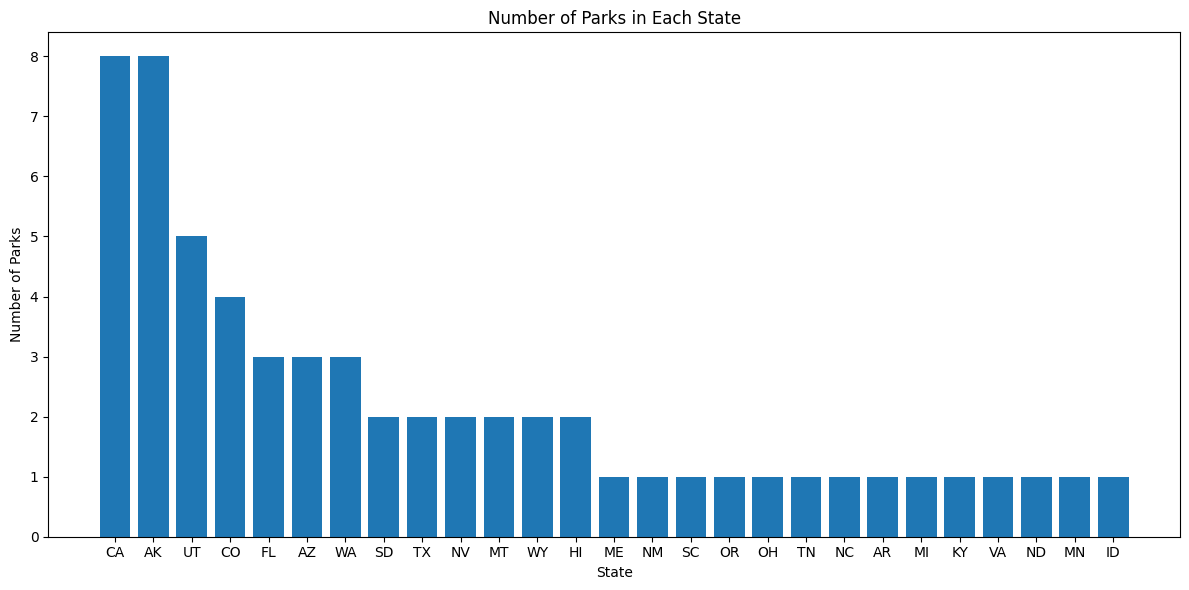

In [3]:
# count the number of parks in each state
state_counts = Counter()

for state in parks['State']:
    for s in state.split(','):
        state_counts[s.strip()] += 1

# plot in order of number of parks
state_counts = dict(state_counts)
state_counts = dict(sorted(state_counts.items(), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(12, 6))
plt.bar(state_counts.keys(), state_counts.values())
plt.xlabel('State')
plt.ylabel('Number of Parks')
plt.title('Number of Parks in Each State')
plt.tight_layout()
plt.show()

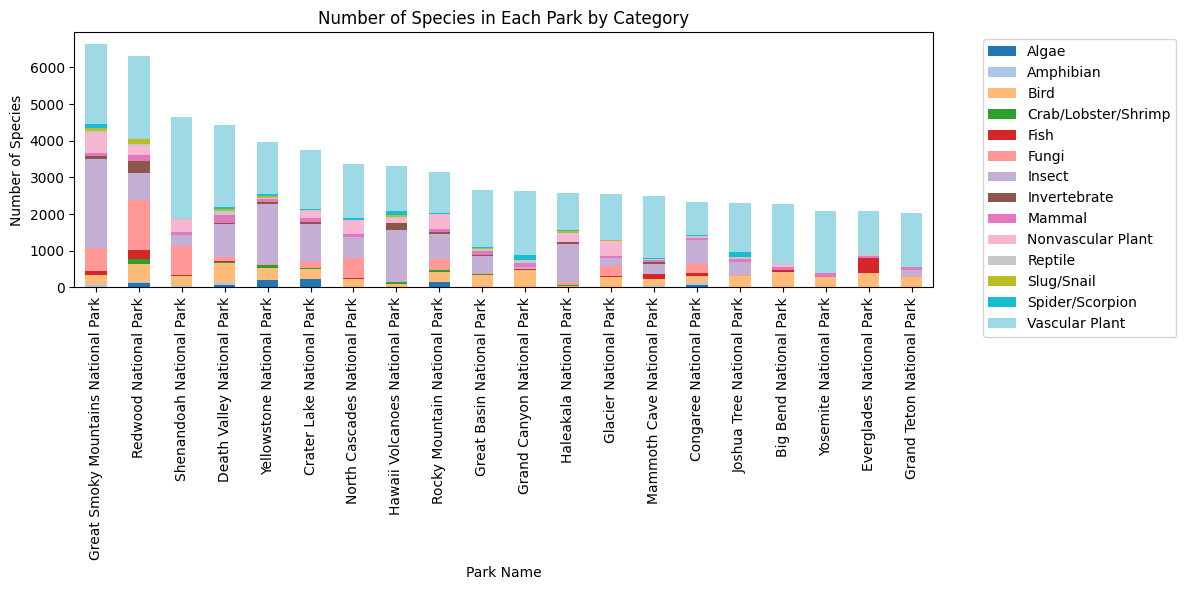

In [4]:
# Compute total species per park and get the top 10 parks, sorted
top_parks = species.groupby('Park Name').size().nlargest(20).index

# Filter dataset for only top parks
species_top = species[species['Park Name'].isin(top_parks)]

# Group by park and category, then reshape for stacked bar plot
species_cat = species_top.groupby(['Park Name', 'Category']).size().unstack().fillna(0)

# Reorder to ensure the x-axis follows the most diverse parks
species_cat = species_cat.loc[top_parks]  

# Plot
colors = mpl.colormaps['tab20'].colors  # 'tab20' provides 20 distinct colors
ax = species_cat.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab20')

# Formatting
plt.title('Number of Species in Each Park by Category')
plt.ylabel('Number of Species')
plt.xlabel('Park Name')
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside
plt.tight_layout()

plt.show()

In [5]:
# Get species total for each park
species_total = species.groupby('Park Name').size()

# Assign a name to the Series
species_total = species_total.rename("Species Count").astype(int)

# Join to parks data
parks = parks.join(species_total, on='Park Name').sort_values('Park Name')

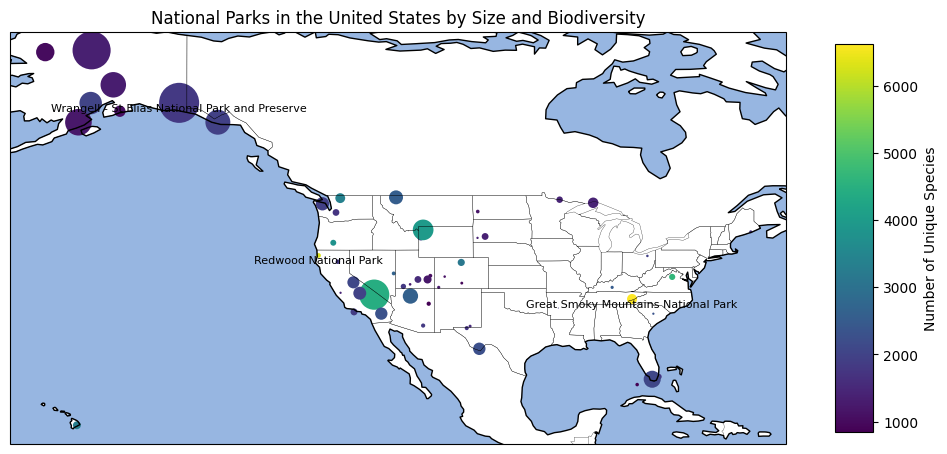

In [6]:
# Create a map
fig = plt.figure(figsize=(10, 10))

# Add a map projection
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Add natural features
ax.add_feature(cfeature.LAND, facecolor='white')
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=.2)
ax.add_feature(cfeature.STATES, linestyle='-', linewidth=.2)

# Normalize the species count to get a suitable color scale
norm = mpl.colors.Normalize(vmin=parks['Species Count'].min(), vmax=parks['Species Count'].max())

# Create scatter plot for parks with color reflecting 'Species Count'
scatter = ax.scatter(
    parks['Longitude'], parks['Latitude'], 
    c=parks['Species Count'], s=parks['Acres'] / 10000,
    cmap='viridis', norm=norm, alpha=1, edgecolors='none'
)

# Add labels for specific parks
for park in ['Great Smoky Mountains National Park', 
             'Wrangell - St Elias National Park and Preserve', 
             'Redwood National Park']:
    row = parks[parks['Park Name'] == park]
    if not row.empty:
        ax.text(row['Longitude'].iloc[0], row['Latitude'].iloc[0], park, 
                fontsize=8, ha='center', va='top')

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', shrink=0.4, aspect=10)
cbar.set_label('Number of Unique Species')

# Add title
plt.title('National Parks in the United States by Size and Biodiversity')

# Layout and show
plt.tight_layout()
plt.show()
